In [1]:
import sys
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import string
import pickle
import xml.etree.ElementTree as ET
import xmltodict

In [2]:
MIN_WIDTH_BOX=5
MIN_HEIGHT_BOX=5
def sanitize_coord(coordinates, width, height):
    """
    points are: [[xmin, ymin], [xmax, ymin], [xmin, ymax], [xmax, ymax]]
    it sanitize the coordinates that are extracted from a xml file. Valid for this dataset,
    to be updated in case the dataset changes
    Returning as dict: xmin, ymin, xmax, ymax
    :param coordinates:[[xmin, ymin], [xmax, ymin], [xmin, ymax], [xmax, ymax]]
    :return: dict with xmin, ymin, xmax, ymax coordinates
    """
    coordinates = coordinates.split()
    points = []
    for point in coordinates:
        point = point.split(',')
        points.append(point)
    new_points = {
        'xmin': points[0][0],
        'ymin': points[0][1],
        'xmax': points[3][0],
        'ymax': points[3][1]
    }
    # logger.info(new_points)
    # logger.info('width: {w}, height: {h}'.format(w=width, h=height))
    # check if coords are inverted
    if int(new_points['ymin']) > int(new_points['ymax']):
        logger.info('I found you y!')
        temp = int(new_points['ymin'])
        new_points['ymin'] = int(new_points['ymax'])
        new_points['ymax'] = temp
    if int(new_points['xmin']) > int(new_points['xmax']):
        logger.info('I found you x!')
        temp = new_points['xmin']
        new_points['xmin'] = int(new_points['xmax'])
        new_points['xmax'] = temp
    if int(new_points['ymin']) < 0:
        logger.info('Found some ymin at zero:')
        new_points['ymin'] = 0
    if int(new_points['xmin']) < 0:
        logger.info('Found some xmin at zero')
        new_points['xmin'] = 0
    if int(new_points['ymax']) > height:
        logger.info('Found some ymax beyond height: \nwidth: {w}, height: {h}\nnew_point["ymax"]: {npyx}' \
                    .format(w=width, h=height, npyx=new_points['ymax']))
        new_points['ymax'] = height
    if int(new_points['xmax']) > width:
        logger.info('Found some xmax beyond height: \nwidth: {w}, height: {h}\nnew_point["xmax"]: {npxx}' \
                    .format(w=width, h=height, npxx=new_points['xmax']))
        new_points['xmax'] = width

    if (int(new_points['xmax']) - int(new_points['xmin'])) < MIN_WIDTH_BOX or \
            (int(new_points['ymax']) - int(new_points['ymin'])) < MIN_HEIGHT_BOX:
        logger.info('Box {} was too small. Going to delete it'.format(new_points))
        new_points = None
    return new_points

In [3]:
def read_xml(path):
    # Read file 
    xml_data=open(path).read()
    # return dictionary of the file
    xmlDict=xmltodict.parse(xml_data)
    return xmlDict  

In [4]:
# dict={xmin:values,}
def drawrect_cv(image,list,rect_color=(0,0,0),rect_width=2):
    for dict in list:
        xmin=dict['xmin']
        ymin=dict['ymin']
        xmax=dict['xmax']
        ymax=dict['ymax']
        rect_color=(0,0,0) 
        rect_width=2
        cv2.rectangle(image,
                      (int(xmin),int(ymax)),
                      (int(xmax),int(ymin)),
                      rect_color,
                      rect_width)  
    cv2.imshow('image',image) 
    cv2.waitKey(0)    
from matplotlib.patches import Rectangle 

def drawrect_plt(img,list,rect_color=(0,0,0),rect_width=2):
    plt.imshow(img)
    for dict in list:
        xmin=int(dict['xmin'])
        ymin=int(dict['ymin'])
        xmax=int(dict['xmax'])
        ymax=int(dict['ymax'])
        #plt.imshow(img[:,:,0])
        #plt.imshow(img[:,:,1])
        ax = plt.gca()
        rect = Rectangle((xmin,ymin),
                     (xmax-xmin),
                     (ymax-ymin),
                     linewidth=1,
                     edgecolor='r',
                     facecolor='none')
        ax.add_patch(rect)
        

In [5]:
folderpath = 'data/images'
files = os.listdir(folderpath)

In [20]:
df=pd.DataFrame(files,columns=['filename'])
df['image_path']='data/images/'+df['filename']
df['label_path_xml']='data/labels/'+df['filename'].apply(lambda x:x.replace('PNG','xml'))
df['label_path']='data/labels/'+df['filename'].apply(lambda x:x.replace('PNG','txt'))


In [21]:
df.head()

,filename,image_path,label_path_xml,label_path
0,00001.PNG,data/images/00001.PNG,data/labels/00001.xml,data/labels/00001.txt
1,00005.PNG,data/images/00005.PNG,data/labels/00005.xml,data/labels/00005.txt
2,00006.PNG,data/images/00006.PNG,data/labels/00006.xml,data/labels/00006.txt
3,00008.PNG,data/images/00008.PNG,data/labels/00008.xml,data/labels/00008.txt
4,00009.PNG,data/images/00009.PNG,data/labels/00009.xml,data/labels/00009.txt


In [58]:
def getimagedimention(xmlpath):
    xmldata=read_xml(xmlpath)
    dimention=xmldata['annotation']['size']
    return np.array([int(dimention['width']),int(dimention['height']),int(dimention['depth'])])

In [59]:
df['image_size']=df['label_path_xml'].apply(getimagedimention)

In [60]:
def getbndboxdimention(xmlpath):
    xmldata=read_xml(xmlpath)
    l=[]
    o=xmldata['annotation']['object']
    dimention=o
    if isinstance(o,type(l)):
        return dimention
    else:
        l.append(dimention)
        return l   

In [61]:
def gettablecount(xmlpath):
    xmldata=read_xml(xmlpath)
    o=xmldata['annotation']['object']
    if isinstance(o,list):
        return len(o)
    else:
        return 1

In [62]:
df['bbox_count']=df['label_path_xml'].apply(gettablecount)
df['tables']=df['label_path_xml'].apply(getbndboxdimention)


In [63]:
def getlimits(listoftables):
    limits=[]
    for x in listoftables:
        x=x['bndbox']
        limits.append([int(x['xmin']),int(x['ymin']),int(x['xmax']),int(x['ymax'])])
    return limits

In [64]:
df['bbox']=df['tables'].apply(getlimits)
df.head(3)

,filename,image_path,label_path_xml,label_path,image_size,bbox_count,tables,bbox
0,00001.PNG,data/images/00001.PNG,data/labels/00001.xml,data/labels/00001.txt,"[1126, 1596, 3]",1,"[{'name': 'Table', 'pose': 'Unspecified', 'tru...","[[15, 442, 1095, 1467]]"
1,00005.PNG,data/images/00005.PNG,data/labels/00005.xml,data/labels/00005.txt,"[1063, 844, 3]",1,"[{'name': 'Table', 'pose': 'Unspecified', 'tru...","[[327, 543, 904, 834]]"
2,00006.PNG,data/images/00006.PNG,data/labels/00006.xml,data/labels/00006.txt,"[682, 845, 3]",5,"[{'name': 'Table', 'pose': 'Unspecified', 'tru...","[[18, 56, 267, 256], [331, 111, 572, 251], [15..."


<AxesSubplot:ylabel='Frequency'>

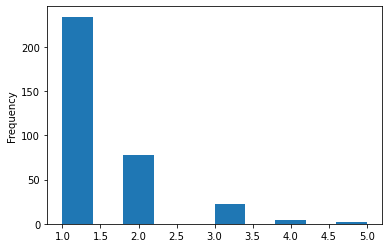

In [65]:
df.bbox_count.plot(kind='hist')

In [66]:
df.to_csv("data/data.csv", index=False)

In [67]:
from tqdm.notebook import tqdm 
from utils.bounding_box import norm_bbox , voc_to_yolo

In [68]:
df.columns

Index(['filename', 'image_path', 'label_path_xml', 'label_path', 'image_size',
       'bbox_count', 'tables', 'bbox'],
      dtype='object')

In [71]:
cnt = 0
all_bboxes = []
for row_idx in tqdm(range(df.__len__())):
    row = df.iloc[row_idx]
    image_height = row['image_size'][0]
    image_width  = row['image_size'][1]
    bboxes_coco  = np.array(row['bbox']).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = [0]*num_bbox
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_yolo  = voc_to_yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
            annot = ' '.join(annot)
            annot = annot.strip(' ')
            f.write(annot)
print('Missing:',cnt)

  0%|          | 0/340 [00:00<?, ?it/s]

Missing: 0
